In [70]:
# Importing required libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pickle
import os

In [67]:
pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [68]:
import os
print("Running from:", os.getcwd())


Running from: C:\Users\ASUS\OneDrive\Desktop\Intern project


In [69]:
# NOTE: Please replace the path below with the path to the 'cifar-10-batches-py' folder on your own device.
# This should be the full directory path where the dataset has been extracted.
folder = os.path.join(os.getcwd(), "cifar-10-batches-py")


In [59]:
# # Function to unpickle CIFAR-10 data files
def unpickle(file):
    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data

# # Load a single CIFAR-10 batch file
def load_cifar10_batch(folder, batch_name):
    batch = unpickle(os.path.join(folder, batch_name))
    X = batch[b'data']
    y = batch[b'labels']
    X = X.reshape(len(X), 3, 32, 32).transpose(0, 2, 3, 1).astype('float32')
    return X, np.array(y)


In [31]:
# Load only the required classes (e.g., airplane, car, bird)
def load_cifar10_subset(folder, selected_classes, batches=[1, 2]):
    X_all, y_all = [], []
    for i in batches:
        X, y = load_cifar10_batch(folder, f'data_batch_{i}')
        mask = np.isin(y, selected_classes)
        X_all.append(X[mask])
        y_all.append(y[mask])
    return np.concatenate(X_all), np.concatenate(y_all)
    
# Normalize pixel values and one-hot encode labels
def preprocess_data(X, y, selected_classes):
    X = X / 255.0
    X = X.reshape(X.shape[0], -1)
    label_map = {cls: i for i, cls in enumerate(selected_classes)}
    y = np.array([label_map[label] for label in y]).reshape(-1, 1)
    onehot = OneHotEncoder(sparse_output=False)
    y_onehot = onehot.fit_transform(y)
    return X, y_onehot, y.ravel()


In [62]:
# This is the path to the CIFAR-10 dataset on my local system.
# Kindly replace this path with the location of the 'cifar-10-batches-py' folder on your own machine while evaluating.
folder = r"C:\Users\ASUS\Downloads\cifar-10-batches-py"


In [63]:
import os

# The folder we're expecting CIFAR-10 data to be in
folder = os.path.join(os.getcwd(), "cifar-10-batches-py")
print("Looking inside folder:", folder)

# List contents
if os.path.exists(folder):
    print("Folder exists. Files inside:")
    print(os.listdir(folder))
else:
    print("Folder not found!")


Looking inside folder: C:\Users\ASUS\OneDrive\Desktop\Intern project\cifar-10-batches-py
Folder exists. Files inside:
['batches.meta', 'data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5', 'readme.html', 'test_batch']


In [64]:
with open("cifar-10-batches-py/data_batch_1", "rb") as f:
    print("File opened successfully.")

File opened successfully.


In [65]:
# Path to local dataset folder
folder = os.path.join(os.getcwd(), "cifar-10-batches-py")
selected_classes = [0, 1, 2]  # # Specify classes to classify (0: airplane, 1: automobile, 2: bird)

# Load and filter dataset
X, y = load_cifar10_subset(folder, selected_classes)
X, y_onehot, y_labels = preprocess_data(X, y, selected_classes)

# Split into training and testing sets
X_train, X_test, y_train, y_test, y_train_labels, y_test_labels = train_test_split(
    X, y_onehot, y_labels, test_size=0.2, random_state=42
)

In [37]:
# # ReLU activation function and its derivative
def relu(x):
    return np.maximum(0, x)

def d_relu(x):
    return x > 0
    
# Softmax function for output layer
def softmax(z):
    e_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return e_z / np.sum(e_z, axis=1, keepdims=True)

# Cross-entropy loss function
def compute_loss(y_hat, y_true):
    eps = 1e-9
    return -np.mean(np.sum(y_true * np.log(y_hat + eps), axis=1))


In [38]:
# Initialize weights and biases for all layers
def initialize_weights(n_input, n_h1, n_h2, n_out):
    w1 = np.random.randn(n_input, n_h1) * 0.01
    b1 = np.zeros((1, n_h1))
    w2 = np.random.randn(n_h1, n_h2) * 0.01
    b2 = np.zeros((1, n_h2))
    w3 = np.random.randn(n_h2, n_out) * 0.01
    b3 = np.zeros((1, n_out))
    return w1, b1, w2, b2, w3, b3


In [39]:
# One full training step: forward + backprop + update
def train_step(X, y, w1, b1, w2, b2, w3, b3, lr):
    # Forward
    z1 = X.dot(w1) + b1
    a1 = relu(z1)
    z2 = a1.dot(w2) + b2
    a2 = relu(z2)
    z3 = a2.dot(w3) + b3
    out = softmax(z3)

    loss = compute_loss(out, y)

    # Backward
    d_out = out - y
    dw3 = a2.T.dot(d_out) / X.shape[0]
    db3 = np.sum(d_out, axis=0, keepdims=True) / X.shape[0]

    da2 = d_out.dot(w3.T)
    dz2 = da2 * d_relu(z2)
    dw2 = a1.T.dot(dz2) / X.shape[0]
    db2 = np.sum(dz2, axis=0, keepdims=True) / X.shape[0]

    da1 = dz2.dot(w2.T)
    dz1 = da1 * d_relu(z1)
    dw1 = X.T.dot(dz1) / X.shape[0]
    db1 = np.sum(dz1, axis=0, keepdims=True) / X.shape[0]

    # Update weights
    w1 -= lr * dw1
    b1 -= lr * db1
    w2 -= lr * dw2
    b2 -= lr * db2
    w3 -= lr * dw3
    b3 -= lr * db3

    return w1, b1, w2, b2, w3, b3, loss


In [49]:
# Custom function to create batches
def get_batches(X, y, batch_size):
    for i in range(0, X.shape[0], batch_size):
        yield X[i:i+batch_size], y[i:i+batch_size]
        

In [71]:
input_size = X_train.shape[1]
h1_size = 512
h2_size = 256
output_size = 3
lr = 0.02
epochs = 50
batch_size = 128
attempt = 0
accuracy = 0

while accuracy < 60:
    attempt += 1
    print(f"\nAttempt #{attempt}")
    
    w1, b1, w2, b2, w3, b3 = initialize_weights(input_size, h1_size, h2_size, output_size)
    loss_history = []

    for epoch in range(epochs):
        batch_losses = []
        for Xb, yb in get_batches(X_train, y_train, batch_size):
            w1, b1, w2, b2, w3, b3, loss = train_step(Xb, yb, w1, b1, w2, b2, w3, b3, lr)
            batch_losses.append(loss)
        avg_loss = np.mean(batch_losses)
        loss_history.append(avg_loss)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f}")

    y_pred = predict(X_test, w1, b1, w2, b2, w3, b3)
    accuracy = np.mean(y_pred == y_test_labels) * 100
    print(f"Accuracy: {accuracy:.2f}%")

print(f"\nTraining complete. Final Accuracy = {accuracy:.2f}% after {attempt} attempt(s)")




Attempt #1
Epoch 10 | Loss: 1.0061
Epoch 20 | Loss: 0.7761
Epoch 30 | Loss: 0.7051
Epoch 40 | Loss: 0.6529
Epoch 50 | Loss: 0.6075
Accuracy: 74.48%

Training complete. Final Accuracy = 74.48% after 1 attempt(s)


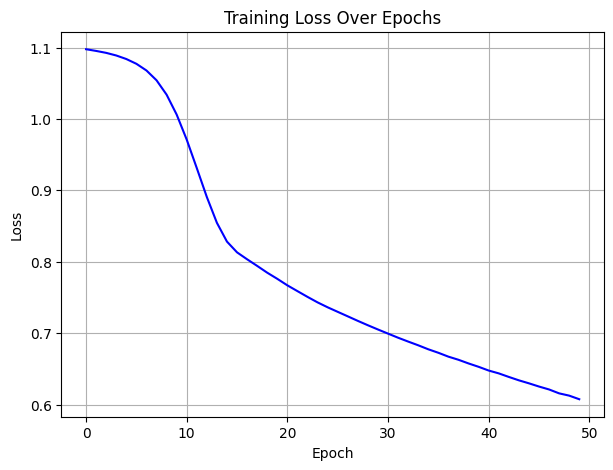

In [72]:
# Plotting training loss after last attempt
plt.figure(figsize=(7, 5))
plt.plot(loss_history, color='blue')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [73]:
# # Function to make predictions
def predict(X, w1, b1, w2, b2, w3, b3):
    z1 = X.dot(w1) + b1
    a1 = relu(z1)
    z2 = a1.dot(w2) + b2
    a2 = relu(z2)
    z3 = a2.dot(w3) + b3
    y_prob = softmax(z3)
    return np.argmax(y_prob, axis=1)


In [53]:
y_pred = predict(X_test, w1, b1, w2, b2, w3, b3)
accuracy = np.mean(y_pred == y_test_labels) * 100

print(f"\n Final Accuracy on test set: {accuracy:.2f}%")


 Final Accuracy on test set: 74.73%


In [56]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import numpy as np

# Predict on test set
y_pred = predict(X_test, w1, b1, w2, b2, w3, b3)
accuracy = np.mean(y_pred == y_test_labels) * 100

# Compute metrics
cm = confusion_matrix(y_test_labels, y_pred)
precision = precision_score(y_test_labels, y_pred, average=None, zero_division=0)
recall = recall_score(y_test_labels, y_pred, average=None, zero_division=0)
f1 = f1_score(y_test_labels, y_pred, average=None, zero_division=0)

# Print results
print("\nEvaluation Metrics:")
print("Final Accuracy: {:.2f}%".format(accuracy))
print("Confusion Matrix:")
print(cm)
print("Precision (per class):", precision)
print("Recall (per class):", recall)
print("F1 Score (per class):", f1)

# Show if any classes were never predicted
missed = np.setdiff1d(np.unique(y_test_labels), np.unique(y_pred))
if len(missed) > 0:
    print("Warning: Some classes were never predicted:", missed)




Evaluation Metrics:
Final Accuracy: 74.73%
Confusion Matrix:
[[318  51  49]
 [ 44 292  38]
 [ 87  35 289]]
Precision (per class): [0.70824053 0.77248677 0.76861702]
Recall (per class): [0.76076555 0.78074866 0.70316302]
F1 Score (per class): [0.73356401 0.77659574 0.73443456]


In [57]:
print(f"\nFinal Accuracy on test set: {accuracy:.2f}%")


Final Accuracy on test set: 74.73%
